The sample notebook walks you through the example of setting up an AWS Glue ETL job to load Identity Graph datab based on the canonical model that you saw in the earlier notebook. The high level flow is as in diagram:

![]( 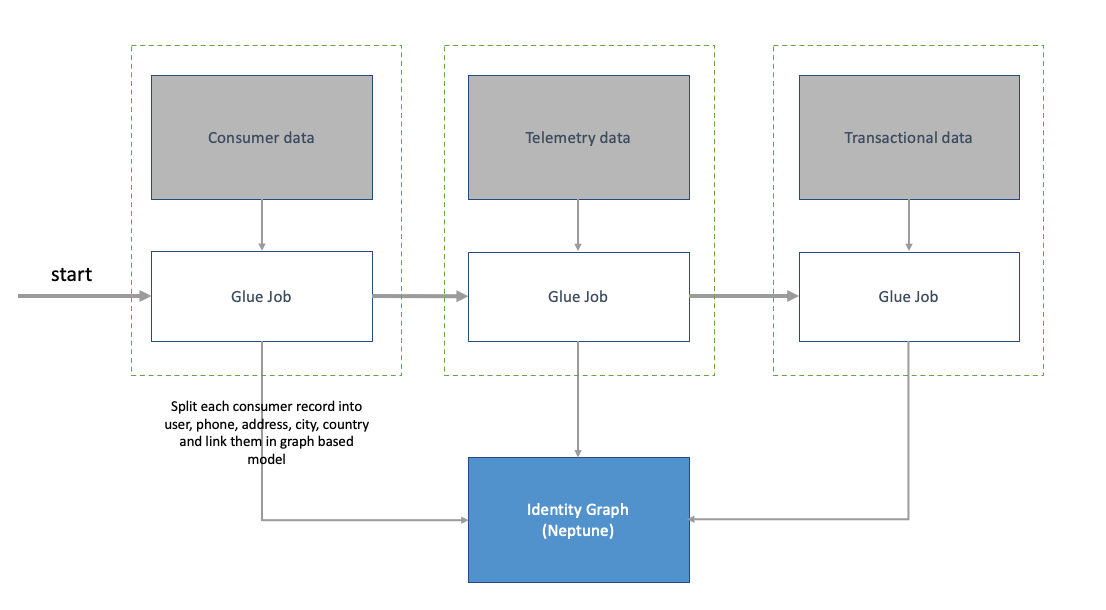)

## Source Data

The use of graph for identity resolution and Consumer 360 provides countless possibilities to stitch disparate datasets together for new insights. The following sections list a number of common datasets that may be found within an organization for building an identity graph.  This is not an exhaustive list and many organizations will have other datasets that may be useful for these purposes.  Primarily, organizations will have a combination of user profile data, user logs (from websites or mobile applications), and product transaction data.  Beyond these datasets, customers may also have access to non-private, third-party information, such as census data, social media posts, call center data, or others that may be combined with these datasets to generate further insights.  Below, we will cover some background on the basic datasets needed to get started.

### Consumer Data

Most organizations will have first-party data related to their known consumers.  This could be in the form of data hosted in a Customer Relationship Management (CRM) platform, in the form of user profiles in an online platform, or some other database containing a person and their identifying attributes.  In many cases, this data may be considered Personal Identifiable Information, or PII, and should be stored in a secure manner with a user’s privacy kept in mind.  As an example, a very basic representation of this data is shown in the table below using fake data.

| Username/ID | First Name  | Last Name  | Address       | Phone Number | Email Address | Birthday |
| ----------- | ----------- | ----- | ----- | ----- | ----- | ----- |
| larry49      | Larry       | Phillips | 46505 William Flat Suite 376\nLeslieside, MS 54982 | 780-995-4351 | lphillips@gmail.com | 3/6/1989 |
| shawn92 | Shawn | Howard | 69792 Nicholas Landing\nConradview, MD 73278 | 512.842.6744 | showard@yahoo.com | 12/12/1973 |
| robert62 | Robert | Montgomery | 5429 Schroeder Center\nNew Beth, MO 13081 | (901)122-1751 | robmont@gmail.com | 9/5/1996 |
| cynthia73 | Cynthia | Williams | 587 Scott Valley Apt. 259\nNorth Lisahaven, RI 47817 | 161.468.1526 | cynthiaw@yahoo.com | 2/18/1987 |


For the etl example we are going to generate some Fake data, if you data is already in format upload your data in S3 bucket

In [ ]:
%%bash 

pip3 install faker

In [ ]:
import csv
import random
from faker import Faker
import numpy as np

myseed = 1234

Faker.seed(myseed)
random.seed(myseed)
np.random.seed(myseed)

print(Faker().uuid4())
print(random.random())
print(np.random.normal(0, 25, size=10))

In [ ]:

fake = Faker()
userSize = 1000

usersList = []
for x in range(userSize):
    newUser = {}
    newUser['id'] =  Faker().unique.user_name()
    #newUser['status:String'] = 'Active' if random.random() < 0.98 else 'Inactive'
    newUser['name'] = fake.name()
    newUser['phone'] = fake.phone_number()
    newUser['email'] = fake.email()
    newUser['city'] = fake.city()
    newUser['country'] = fake.country()
    newUser['zipcode'] = fake.zipcode()
    # newUser['address'] = fake.address()
    newUser['joinedDate'] = fake.date_between(start_date='-5y')
    newUser['updatedDate'] = fake.date_between(start_date=newUser['joinedDate'])
    #newUser['reputation:Double'] = np.random.normal(0, 25)
    #newUser['altruism:Double'] = abs(np.random.normal(0, 10))
    #newUser['duty:Double'] = abs(np.random.normal(0, 3))
    #newUser['mischief:Double'] = np.random.normal(0, 1.5)
    #newUser['malice:Double'] = abs(np.random.normal(0, 1))
    #newUser['atrisk:Double'] = abs(np.random.normal(0, 1))
    usersList.append(newUser)
    
print(usersList[1])

In [ ]:
toExport = [usersList]
filenames = ['2021_user_vertices']

for index, currentList in enumerate(toExport):
    with open('./etl/' + filenames[index] + '.csv', 'w') as csvFile:
        writer = csv.DictWriter(csvFile, escapechar='\n',quoting=csv.QUOTE_NONE,fieldnames = currentList[0].keys())
        # writer.writeheader()
        for p in currentList:
            writer.writerow(p)
    csvFile.close()

In [ ]:
%%bash

aws s3 cp ./etl/ s3://abhmish-neptune-glue/data/ --recursive

## Set default property values

In [ ]:
s3_bucket = "s3://<bucketname>/"
iamrole = "<rolename>"
iamroleArn = "<roleArn>"
glue_database_name = "identitygraphsource"
glue_table_demographics = "person"
job_demographics_name = "job_demographics_name"
job_usetelemetry_name = "job_demographics_name"
job_transactions_name = "job_transactions_name"
aws_region = "us-west-2"
db_vpc_id = "<vpcid>"
neptune_endpoint = 'wss://<neptuneclusterendpoint>:8182/gremlin'


## Import boto3 and create clients

In [ ]:
#create boto3 clients

import boto3

session = boto3.Session(region_name=aws_region)

ec2_resource = session.resource("ec2")
ec2_client = session.client("ec2")
glue_client = session.client("glue")

In [ ]:
listOfVPCs = client.describe_vpcs() 

listOfVPCs["Vpcs"]

## Create Glue database

In [ ]:
response = glue_client.create_database(
    DatabaseInput={
        'Name': 'identitygraphsource',
        'Description': 'identitygraphsource'
    }
)

print(response)

## Create Glue table

In [ ]:
response = glue_client.create_table(
    DatabaseName='identitygraphsource',
        TableInput={
            'Name': 'person',
            'Description': 'person',
            'StorageDescriptor': {
                "Columns":[ 
                    {"Name":"id", "Type":"string"}, 
                    {"Name":"name", "Type":"string"}, 
                    {"Name":"phone", "Type":"string"}, 
                    {"Name":"email", "Type":"string"}, 
                    {"Name":"city", "Type":"string"}, 
                    {"Name":"country", "Type":"string"}, 
                    {"Name":"pincode", "Type":"string"}, 
                    {"Name":"joinedDate", "Type":"string"}, 
                    {"Name":"updatedDate", "Type":"string"}
                ],
                "Location": s3_bucket + "data/",
                "InputFormat": "org.apache.hadoop.mapred.TextInputFormat",
                "SerdeInfo":{ 
                    "SerializationLibrary":"org.apache.hadoop.hive.serde2.OpenCSVSerde",
                    "Parameters":{ 
                        "separatorChar":",",
                        "quoteChar":"\""
                    }
                }
            },
            "Parameters":{ 
                "componenttype":"vertex"
            } 
        }
    )

## upload script to s3 bucket paths
 s3://&lt;bucketname>/script/neptune-glue-person.py


In [ ]:
%%bash

aws s3 cp neptune-glue-person.py s3://abhmish-neptune-glue/script/neptune-glue-person.py

## setup neptune python util
 s3://&lt;bucketname>/lib/neptune_python_utils.zip

In [ ]:
%%bash

aws s3 cp neptune_python_utils.zip s3://abhmish-neptune-glue/lib/neptune_python_utils.zip

## Create Glue Connections

In [ ]:
# find subnets


session = boto3.Session(region_name=aws_region)

ec2_resource = session.resource("ec2")
ec2_client = session.client("ec2")
glue_client = session.client("glue")

subnet_ids = []

for vpc in ec2_resource.vpcs.all():
    
    if vpc.id == db_vpc_id:
        for subnet in vpc.subnets.all():
            subnet_ids.append(subnet.id)


subnets = ec2_client.describe_subnets(SubnetIds=subnet_ids)
#print(ec2_client.describe_subnets(SubnetIds=subnet_ids))

In [ ]:
# create connection objects from subnets
connections = []

for subnet in subnets["Subnets"]:
    connectionName = 'connection' + subnet["SubnetId"]
    
    response = glue_client.create_connection(
        ConnectionInput={
            'Name': connectionName,
            'Description': connectionName,
            'ConnectionType': 'NETWORK',
            'ConnectionProperties': {},
            'PhysicalConnectionRequirements': {
                'SubnetId': subnet["SubnetId"],
                'SecurityGroupIdList': [
                    'sg-0d777aa7be053ddf8',
                ],
                'AvailabilityZone': subnet["AvailabilityZone"]
            }
        }
    )
    
    connections.append(connectionName)
    
    print(response)
    

In [ ]:
connections

## Create Glue Job

In [ ]:
response = glue_client.create_job(
    Name='neptune104',
    Description='neptune104',
    Role= iamrole,
    ExecutionProperty={
        'MaxConcurrentRuns': 123
    },
    Command={
        'Name': 'glueetl',
        'ScriptLocation': s3_bucket + 'script/neptune-glue-person.py',
        'PythonVersion': '3'
    },
    DefaultArguments={
        '--additional-python-modules': s3_bucket + 'lib/neptune_python_utils.zip',
        '--extra-py-files': s3_bucket + 'lib/neptune_python_utils.zip',
        '--NEPTUNE_CONNECTION_NAME': neptune_endpoint,
        '--DATABASE_NAME': 'identitygraphsource',
        '--CONNECT_TO_NEPTUNE_ROLE_ARN': iamroleArn,
        '--AWS_REGION':'us-west-2'
        
    },
    NonOverridableArguments={},
    Connections={
        'Connections': connections
    },
    MaxRetries=0,
    Timeout=123,
    GlueVersion='2.0',
    NumberOfWorkers=123,
    WorkerType='G.2X'
)

## Start Glue Job

In [ ]:
%%bash

aws glue start-job-run --job-name 'neptune104'

## Check Job Status

In [ ]:
%%bash

aws glue get-job-run --job-name 'neptune104' --run-id 'jr_124a811c50e8763087f3232c6e5ee394b0d7f50bfbd6030325dfce12df45b84f'

## Test query to verify data

In [ ]:
%%gremlin


g.V().hasLabel("User").limit(20).outE().inV().optional(outE().inV()).path()